# Workshop 1: Introduction to `PyPSA` & TYNDP reference grids

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `linopy`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `linopy` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa matplotlib cartopy highspy
```
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |
|  | **not used in this course** |
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |


:::{note}
Links in the table lead to documentation for each component.
:::

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components.

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

# Using the PyPSA framework: a simple example

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket 🚀 in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy
%env HV_DOC_HTML=true
```
:::

In [ ]:
# For executing this notebook in Google Colab
# !pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy
# %env HV_DOC_HTML=true

### Simple electricity market problem
Copyright (c) 2025, Iegor Riepin

generator 1: "gas" -- marginal cost 70 EUR/MWh -- capacity 50 MW

generator 2: "nuclear" -- marginal cost 10 EUR/MWh -- capacity 100 MW

load: "Consumer" -- demand 120 MW

single time step ("now")

single node ("Springfield")

### Building a basic network

In [ ]:
# By convention, PyPSA is imported without an alias:
import pypsa

In [ ]:
# First, we create a network object which serves as the container for all components
n = pypsa.Network()

In [ ]:
n

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [ ]:
n.add("Bus", "Springfield", v_nom=380, carrier="AC")

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [ ]:
n.buses

You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components.

The `n.add()` function lets you add any component to the network object `n`:

In [ ]:
n.add(
    "Generator",
    "gas",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "nuclear",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=10,  # €/MWh
    p_nom=100,  # MW
)

The method `n.add()` also allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting. For this, the function takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

As a result, the `n.generators` DataFrame looks like this:

In [ ]:
n.generators

Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [ ]:
n.add(
    "Load",
    "Small town",
    bus="Springfield",
    p_set=120,  # MW
)

In [ ]:
n.loads

## Optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For this dispatch problem, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{s,t};} \sum_{t,s} o_{s} g_{s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{s,t} \leq G_{s}  & \text{generation limits : generator} \\
D_t &= \sum_s g_{s,t} & \text{market clearing : bus} \\
\end{align}

**Decision variables:**

- $g_{s,t}$ is the generator dispatch of technology $s$ at time $t$

**Parameters:**

- $o_{s}$ is the marginal generation cost of technology $s$
- $G_{s}$ is the nominal capacity of technology $s$
- $D_t$ is the power demand in Springfiled at time $t$


With all input data transferred into the PyPSA's data structure (`network`), we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimizes dispatch and investment decisions for least cost adhering to the constraints defined in the network.

The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver (e.g. "highs" and "gurobi"). They need to be installed on your computer, to use them here!

In [ ]:
n.optimize(solver_name="highs")

Let's have a look at the results. The network object `n` contains now the objective value and the results for the decision variables.

In [ ]:
n.objective

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different locations than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [ ]:
n.generators_t.p

In [ ]:
n.buses_t.marginal_price

In [ ]:
n.generators_t.mu_upper

### Explore pypsa model

In [ ]:
n.model

In [ ]:
n.model.constraints

In [ ]:
n.model.constraints["Generator-fix-p-upper"]

In [ ]:
n.model.constraints["Bus-nodal_balance"]

In [ ]:
n.model.objective

# Hands-on Session 1: Building the reference grids

In [16]:
import pypsa
import atlite
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import holoviews as hv
import cartopy.crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

plt.style.use("bmh")

In [5]:
from urllib.request import urlretrieve
from os.path import basename

urls = [
    "https://tubcloud.tu-berlin.de/s/2oogpgBfM5n4ssZ/download/PORTUGAL-2013-01-era5.nc",
]
for url in urls:
    urlretrieve(url, basename(url))

## Load Example Data

First, let's load a pre-composed PyPSA Network:

In [ ]:
n = pypsa.Network("base_extended.nc")

And let's get a general overview of the components in it:

In [7]:
n.component

<bound method Network.component of PyPSA Network 'PyPSA-Eur (tyndp-raw)'
-------------------------------------
Components:
 - Bus: 55
 - Carrier: 1
 - Link: 219
 - Shape: 62
Snapshots: 8760>

We have buses which represent the different nodes in the model where components attach.

In [8]:
n.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,...,generator,sub_network,substation_off,under_construction,country,onshore_bus,substation_lv,tags,geometry,symbol
Bus,,,,,,,,,,,,,,,,,,,,,
AL00,380.0,,20.036884,41.117588,AC,,,1.0,0.0,inf,...,,,True,False,AL,True,True,AL00,POINT (20.036883988642373 41.117587702511265),Substation
AT00,380.0,,14.822183,47.668898,AC,,,1.0,0.0,inf,...,,,True,False,AT,True,True,AT00,POINT (14.822183225330722 47.66889815500068),Substation
BA00,380.0,,17.867837,43.982016,AC,,,1.0,0.0,inf,...,,,True,False,BA,True,True,BA00,POINT (17.867837381251373 43.98201574415207),Substation
BE00,380.0,,4.967931,50.470635,AC,,,1.0,0.0,inf,...,,,True,False,BE,True,True,BE00,POINT (4.96793113501169 50.47063494467691),Substation
BG00,380.0,,25.323948,42.668760,AC,,,1.0,0.0,inf,...,,,True,False,BG,True,True,BG00,POINT (25.323948321769794 42.66875960983357),Substation
CH00,380.0,,8.343017,46.733623,AC,,,1.0,0.0,inf,...,,,True,False,CH,True,True,CH00,POINT (8.343016848147002 46.733622826620646),Substation
CY00,380.0,,33.008947,34.944963,AC,,,1.0,0.0,inf,...,,,True,False,CY,True,True,CY00,POINT (33.00894727583923 34.944962529193454),Substation
CZ00,380.0,,15.663683,49.752662,AC,,,1.0,0.0,inf,...,,,True,False,CZ,True,True,CZ00,POINT (15.663683158456282 49.752662484669656),Substation
DE00,380.0,,10.113400,51.109915,AC,,,1.0,0.0,inf,...,,,True,False,DE,True,True,DE00,POINT (10.113400151400297 51.10991486311772),Substation


Generators which represent generating units (e.g. power plant, wind turbine, PV panel):

In [9]:
n.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,


Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul>

In [10]:
n.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,underwater_fraction,under_construction,tags,geometry,dc,underground,voltage
Link,,,,,,,,,,,,,,,,,,,,,
AL00-GR00-DC,AL00,GR00,,DC,1.0,True,0,inf,600.0,0.0,...,1.0,1.0,0.0,0.000000,False,AL00 > GR00,LINESTRING (20.036883988642373 41.117587702511...,True,True,380
AL00-ME00-DC,AL00,ME00,,DC,1.0,True,0,inf,400.0,0.0,...,1.0,1.0,0.0,0.000000,False,AL00 > ME00,LINESTRING (20.036883988642373 41.117587702511...,True,True,380
AL00-MK00-DC,AL00,MK00,,DC,1.0,True,0,inf,500.0,0.0,...,1.0,1.0,0.0,0.000000,False,AL00 > MK00,LINESTRING (20.036883988642373 41.117587702511...,True,True,380
AL00-RS00-DC,AL00,RS00,,DC,1.0,True,0,inf,250.0,0.0,...,1.0,1.0,0.0,0.000000,False,AL00 > RS00,LINESTRING (20.036883988642373 41.117587702511...,True,True,380
AT00-CH00-DC,AT00,CH00,,DC,1.0,True,0,inf,1200.0,0.0,...,1.0,1.0,0.0,0.000000,False,AT00 > CH00,LINESTRING (14.822183225330722 47.668898155000...,True,True,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SI00-ITN1-DC,SI00,ITN1,,DC,1.0,True,0,inf,1153.0,0.0,...,1.0,1.0,0.0,0.000000,False,SI00 > ITN1,LINESTRING (15.915567665811025 67.869371265229...,True,True,380
SK00-AT00-DC,SK00,AT00,,DC,1.0,True,0,inf,0.0,0.0,...,1.0,1.0,0.0,0.000000,False,SK00 > AT00,LINESTRING (14.822183225330722 47.668898155000...,True,True,380
SK00-CZ00-DC,SK00,CZ00,,DC,1.0,True,0,inf,1100.0,0.0,...,1.0,1.0,0.0,0.000000,False,SK00 > CZ00,LINESTRING (10.113400151400297 51.109914863117...,True,True,380


In [11]:
n.loads_t.p

Load
snapshot
2013-01-01 00:00:00
2013-01-01 01:00:00
2013-01-01 02:00:00
2013-01-01 03:00:00
2013-01-01 04:00:00
...
2013-12-31 19:00:00
2013-12-31 20:00:00
2013-12-31 21:00:00


## Explore Bidding Zones

To begin this section, let's start by examining the spatial resolution of the electricity grid representation 
in the Scenario Building Exercise which is the Bidding Zones.

Let's load the Bidding Zone shapes that we created for the PyPSA model:

In [ ]:
url = "bidding_zones.geojson"
bz = gpd.read_file(url)

Let's have a look at the file:

In [13]:
bz.head()

,zone_name,country,cross_country_zone,geometry
0,AL00,AL,None,"MULTIPOLYGON (((20.56881 41.87367, 20.50041 42..."
1,AT00,AT,None,"MULTIPOLYGON (((16.94357 48.60406, 16.87157 48..."
2,BA00,BA,None,"MULTIPOLYGON (((19.02249 44.85585, 18.84298 44..."
3,BE00,BE,None,"MULTIPOLYGON (((2.52183 51.08698, 2.59023 50.8..."
4,BG00,BG,None,"MULTIPOLYGON (((26.33246 41.71339, 26.54847 41..."


Let's use a nice interactive plotting package to plot the regions.

`.hvplot()` is a powerful and interactive Pandas-like `.plot()` API. You just replace `.plot()` with `.hvplot()` and you get an interactive figure.

Documentation can be found here: https://hvplot.holoviz.org/index.html

In [14]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)

In [18]:
# set the projection to specify for all geoplotting in this notebook
proj = load_projection(dict(name="EqualEarth"))

In [19]:
import hvplot.pandas

hv.extension("bokeh")
bz.hvplot(
    geo=True,
    tiles="OSM",
    hover_cols=["zone_name", "country"],
    c="zone_name",
    frame_height=700,
    alpha=0.2,
    legend=False,
).opts(xaxis=None, yaxis=None, active_tools=["pan", "wheel_zoom"])

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (zone_name,country)

## Explore the Electricity reference grid

The Electricity reference grid in the `PyPSA` model was implemented as HVAC lines that neglect KVL and only net transfer capacities (NTCs).

This is referred to as a `Transport Model`.

In `PyPSA`, this can be represented by the `link` component with carrier set to 'DC'.

Let's have a look at those links:

In [20]:
reference_grid_elec = n.links.query("carrier == 'DC'")
(
    reference_grid_elec.loc[
        :, ["p_nom", "p_nom_opt", "length", "p_nom_extendable"]
    ].head(10)
)

,p_nom,p_nom_opt,length,p_nom_extendable
Link,,,,
AL00-GR00-DC,600.0,0.0,219.635111,False
AL00-ME00-DC,400.0,0.0,189.342890,False
AL00-MK00-DC,500.0,0.0,153.308707,False
AL00-RS00-DC,250.0,0.0,351.420535,False
AT00-CH00-DC,1200.0,0.0,502.028400,False
AT00-CZ00-DC,900.0,0.0,239.946178,False
AT00-DE00-DC,7500.0,0.0,512.754700,False
AT00-HU00-DC,800.0,0.0,324.765187,False
AT00-ITN1-DC,875.0,0.0,464.387903,False


Or we can compute the total transmission capacity of the system in `TWkm`:

In [21]:
total_TWkm = (
    reference_grid_elec.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_elec.length)
    .sum()
    .round(2)
)
print(
    f"Total electricity reference grid has a transmission capacity of {total_TWkm} TWkm."
)

Total electricity reference grid has a transmission capacity of 155.02 TWkm.


We can also check some individual number for specific connections using the `query()` or the `filter(like='<your-filter>')` method.

In [36]:
# example
# `query()`
print(
    reference_grid_elec
    .query("Link.str.contains('DE00-BE00')")
    .p_nom  # in MW
)
# or `filter()`
print(
    reference_grid_elec
    .filter(like="DE00-BE00", axis=0)
    .p_nom
)

Link
DE00-BE00-DC    1000.0
Name: p_nom, dtype: float64
Link
DE00-BE00-DC    1000.0
Name: p_nom, dtype: float64


In [147]:
# Task: extract and filter for specific capacity information from your home country and compare with your data about these connections

Additionally, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the electricity reference grid:

In [153]:
# explore the reference grid
n.plot.explore()

INFO:pypsa.plot.maps:Components rendered on the map: Bus, Link.
INFO:pypsa.plot.maps:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer.


We can also plot the electricity grid by utilizing a handy plotting function:

In [149]:
import cartopy.crs as ccrs
from pypsa.plot.maps import add_legend_lines


def plot_electricity_reference_grid(n, regions, proj):
    lw_factor = 1e3 if n.lines.empty else 2e3

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": proj})
    regions.to_crs(proj.proj4_init).plot(
        ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.75
    )
    n.plot.map(
        ax=ax,
        margin=0.06,
        line_widths=n.lines.s_nom / lw_factor,
        link_widths=n.links.p_nom / lw_factor,
    )

    if not n.lines.empty:
        sizes_ac = [10, 20]
        labels_ac = [f"HVAC ({s} GW)" for s in sizes_ac]
        scale_ac = 1e3 / lw_factor
        sizes_ac = [s * scale_ac for s in sizes_ac]

        legend_kw_ac = dict(
            loc=[0.25, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_ac,
            labels_ac,
            patch_kw=dict(color="rosybrown"),
            legend_kw=legend_kw_ac,
        )

    if not n.links.empty:
        sizes_dc = [1, 5]
        labels_dc = [f"HVDC ({s} GW)" for s in sizes_dc]
        scale_dc = 1e3 / lw_factor
        sizes_dc = [s * scale_dc for s in sizes_dc]

        legend_kw_dc = dict(
            loc=[0.0, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_dc,
            labels_dc,
            patch_kw=dict(color="darkseagreen"),
            legend_kw=legend_kw_dc,
        )

    plt.show()

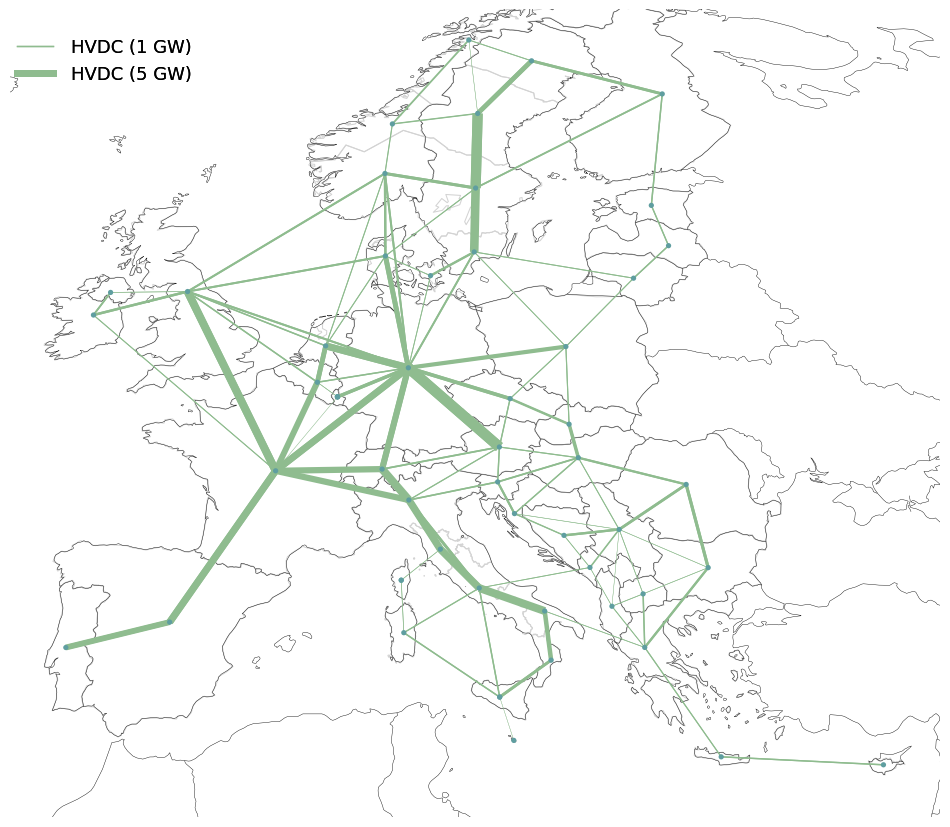

In [152]:
plot_electricity_reference_grid(n, bz, proj)

## Explore the Hydrogen reference grid

Similar to the Electricity reference grid, the H2 reference grid in the `PyPSA` model was implemented using the `link` component to represent the transport model of the Scenario Building exercise.

Let's have a look at those Hydrogen reference grid links:

In [ ]:
reference_grid_h2 = n.links.query("carrier == 'H2 pipeline'")
(
    reference_grid_elec.loc[
        :, ["p_nom", "p_nom_opt", "length", "p_nom_extendable"]
    ].head(10)
)

Again, we can compute the total transmission capacity of the system in `TWkm`:

In [ ]:
total_TWkm = (
    reference_grid_h2.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_h2.length)
    .sum()
    .round(2)
)
print(f"The H2 reference grid has a total transmission capacity of {total_TWkm} TWkm.")

And also extract and check some individual numbers for specific connections:

In [ ]:
# Task: extract and filter for specific capacity information and compare with your data about these connections

Again, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the hydrogen reference grid. 

As we can see, the spatial resolution of the H2 reference grid is different to the electricity reference grid.

In [ ]:
# explore the reference grid
n.plot.explore()

We can also plot the electricity grid by importing and utilizing a handy plotting function:

In [ ]:
def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


def plot_h2_reference_grid(network, map_opts):
    n = network.copy()

    linewidth_factor = 4e3

    n.links.drop(
        n.links.index[~n.links.carrier.str.contains("H2 pipeline")], inplace=True
    )
    h2_pipes = n.links[n.links.carrier == "H2 pipeline"].p_nom
    link_widths_total = h2_pipes / linewidth_factor
    if link_widths_total.notnull().empty:
        print("No base H2 pipeline capacities to plot.")
        return
    link_widths_total = link_widths_total.reindex(n.links.index).fillna(0.0)

    proj = load_projection(dict(name="EqualEarth"))
    n.buses.drop(n.buses.index[~n.buses.carrier.str.contains("H2")], inplace=True)

    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={"projection": proj})
    color_h2_pipe = "#499a9c"
    color_h2_node = "#ff29d9"

    n.plot(
        geomap=True,
        bus_sizes=0.1,
        bus_colors=color_h2_node,
        link_colors=color_h2_pipe,
        link_widths=link_widths_total,
        branch_components=["Link"],
        ax=ax,
        **map_opts,
    )

    sizes = [30, 10]
    labels = [f"{s} GW" for s in sizes]
    scale = 1e3 / 4e3
    sizes = [s * scale for s in sizes]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.01, 1.07),
        frameon=False,
        ncol=2,
        labelspacing=0.8,
        handletextpad=1,
    )

    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color="lightgrey"),
        legend_kw=legend_kw,
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.25, 1.13),
        labelspacing=0.8,
        handletextpad=0,
        frameon=False,
    )

    add_legend_circles(
        ax,
        sizes=[0.2],
        labels=["H2 Node"],
        srid=n.srid,
        patch_kw=dict(facecolor=color_h2_node),
        legend_kw=legend_kw,
    )

    colors = [color_h2_pipe]
    labels = ["H2 Pipeline"]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0, 1.13),
        ncol=1,
        frameon=False,
    )

    add_legend_patches(ax, colors, labels, legend_kw=legend_kw)

    ax.set_facecolor("white")

    plt.show()

In [ ]:
proj = load_projection(dict(name="EqualEarth"))
map_opts = {
    "boundaries": [-11, 30, 34, 71],
    "color_geomap": {
        "ocean": "white",
        "land": "white",
    },
}

In [ ]:
plot_h2_reference_grid(n, map_opts)

# Hands-on Session 2: Extracting insights & Visualization

## Import the solved model

In [39]:
n = pypsa.Network("postnetwork.nc")

INFO:pypsa.io:Imported network elec_s_180_lvopt__730SEG-T-H-B-I-A-solar+p3-linemaxext10-onwind+p0.4-gas+m2.5_2045_custom.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Extract insights from the network: The `PyPSA.statistics` module

Let's investigate the results from the solved model.

First, we would like to see the optimal power plant capacities in the model:

In [156]:
n.statistics().T

,Link
,DC
Optimal Capacity,0.0
Installed Capacity,357523.0
Supply,0.0
Withdrawal,0.0
Energy Balance,0.0
Transmission,0.0
Capacity Factor,0.0
Curtailment,0.0
Capital Expenditure,0.0


In [104]:
(
    n.statistics.optimal_capacity(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    ).div(1e3)  # GW
    .sort_values(ascending=False)
    .to_frame(name="p_nom_opt")
    .query("p_nom_opt>1e-3")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .sort_values(by=["Onshore Wind"], ascending=False)
)

carrier,AC,CCGT,DC,OCGT,Offshore Wind (AC),Offshore Wind (DC),Onshore Wind,Pumped Hydro Storage,Reservoir & Dam,Run of River,...,V2G,battery discharger,coal,lignite,nuclear,offwind,oil,solar rooftop,urban central solid biomass CHP,urban central solid biomass CHP CC
location,,,,,,,,,,,,,,,,,,,,,
GB0 0,0.000000,15.4841,0.000000,0.074,51.076042,21.706286,161.063135,0.4400,0.138300,8.788900,...,270.764307,0.0,0.0,0.0,0.00,3.248492,0.000000,234.774353,2.766000,0.000000
FR1 0,0.000000,0.8810,23.112287,0.088,18.140240,0.000000,157.929605,0.0000,2.170036,0.818170,...,87.062967,0.0,0.0,0.0,0.00,0.000000,0.000000,70.167910,0.021651,0.000000
FR1 1,26.190249,2.8930,17.377370,0.253,0.000000,2.469745,93.236086,0.8080,0.000000,0.108000,...,130.536946,0.0,0.0,0.0,0.00,0.000000,0.542000,105.205519,0.033203,0.397957
FR1 2,80.398170,2.5850,0.000000,0.194,0.000000,0.000000,84.265483,4.1683,5.890515,5.910074,...,90.996946,0.0,0.0,0.0,0.00,0.000000,0.000000,73.338478,0.018839,0.000000
SE2 1,22.050255,0.7090,0.000000,0.000,0.000000,0.000000,61.531460,0.0920,0.564804,0.161000,...,23.665089,0.0,0.0,0.0,1.40,0.017037,0.000000,19.514874,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS1 1,23.025049,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.208600,1.590600,...,16.307842,0.0,0.0,0.0,0.00,0.000000,0.000000,14.635022,0.074979,0.000000
RS1 0,2.721058,0.2000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,10.879500,0.0,0.0,0.0,0.00,0.000000,0.000000,9.763506,0.093915,0.077583
AL1 1,4.925773,0.0000,0.000000,0.000,0.000000,0.000000,0.000000,0.0000,0.094500,0.000000,...,7.929811,0.0,0.0,0.0,0.00,0.000000,0.089855,6.560870,0.000000,0.000000


We can also easily look into the energy balance for a specific carrier by Node. 

So, let's investigate the Hydrogen balance at the Z1 and Z2 nodes of Germany (DE):

In [140]:
(
    n.statistics.energy_balance(
        carrier="H2",
        groupby=["bus", "country", "carrier"]
    )
    .div(1e3)
    .to_frame(name="balance_GW")
    .query("bus.str.contains('DE1 0 H2')")
)

balance_GW
component bus      country carrier                             
Link      DE1 0 H2         H2 Electrolysis             0.001388
                           H2 Fuel Cell               -0.000083
                           H2 pipeline              7596.271798
                           H2 pipeline retrofitted -5539.004444
Load      DE1 0 H2         H2 for industry           -60.000000

... or look at renewable curtailment in the system:

In [141]:
(
    n.statistics.curtailment(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    ).div(1e3)  # GW
    .sort_values(ascending=False)
    .to_frame(name="p_nom_opt")
    .query("p_nom_opt>1e-3")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .sort_values(by=["Onshore Wind"], ascending=False)
)

carrier,Offshore Wind (AC),Offshore Wind (DC),Onshore Wind,Pumped Hydro Storage,Reservoir & Dam,Run of River,Solar,offwind,solar rooftop
location,,,,,,,,,
FR1 2,0.000000,0.0,3529.562871,38304.991499,26529.054331,0.002282,7827.871383,0.0,0.006711
IE5 1,0.000000,0.0,1352.030331,0.000000,6.300578,0.000000,0.002336,0.0,0.000000
PT1 0,0.000000,0.0,507.515879,0.000000,1493.216079,0.003477,1043.866538,0.0,0.009336
PL1 2,0.000000,0.0,478.131303,6491.474715,669.471593,0.000000,0.004134,0.0,0.000000
FR1 0,0.002971,0.0,269.619652,0.000000,9755.407883,0.000000,0.015137,0.0,0.001267
...,...,...,...,...,...,...,...,...,...
DE1 71,0.000000,0.0,0.000000,352.969666,0.000000,0.000000,0.000000,0.0,0.000000
AL1 1,0.000000,0.0,0.000000,0.000000,447.805585,0.000000,187.041855,0.0,60.782309
DE1 77,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001035,0.0,0.000000


## Visualizing results with the `PyPSA.statistics` module

The `PyPSA.statistics` module can also be used to create some really handy static plotting to investigate the results of a model:

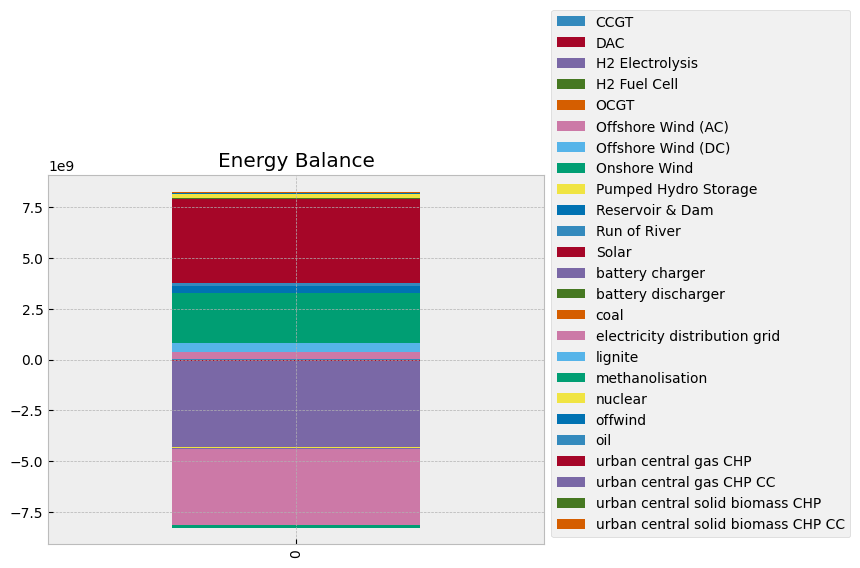

In [142]:
fig, ax = plt.subplots()
n.statistics.energy_balance().loc[:, :, "AC"].groupby(
    "carrier"
).sum().to_frame().T.plot.bar(stacked=True, ax=ax, title="Energy Balance")
ax.legend(bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

In [ ]:
# insert Fabian's cool statistics.plot examples here

Example: With some tweaking and construction, we can use PyPSA's plotting to create some really cool visualizations of the resulting net hydrogen flows in the network: